In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

2022-11-18 17:12:46,819 - 66229 - log_ - INFO - Creating AgentBuildings object
2022-11-18 17:12:46,819 - 66229 - log_ - INFO - Creating AgentBuildings object


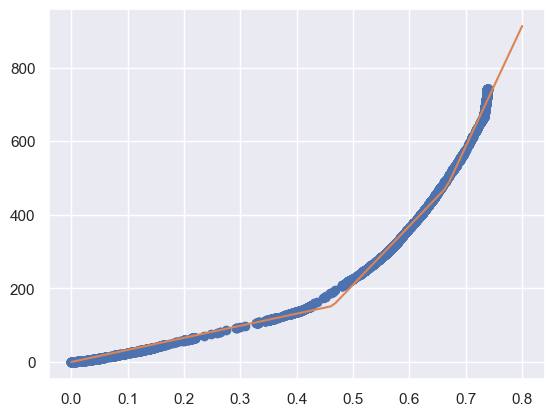

In [12]:
dict_cost, dict_heat = social_planner(climate=2006, smooth=False)
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True)

In [17]:
linearized_renovation_costs["global_0"]

328.46264968775523

In [13]:
threshold_linearized_renovation_costs

global_0    0.463849
global_1    0.202288
global_2    0.072437
dtype: float64

<AxesSubplot:>

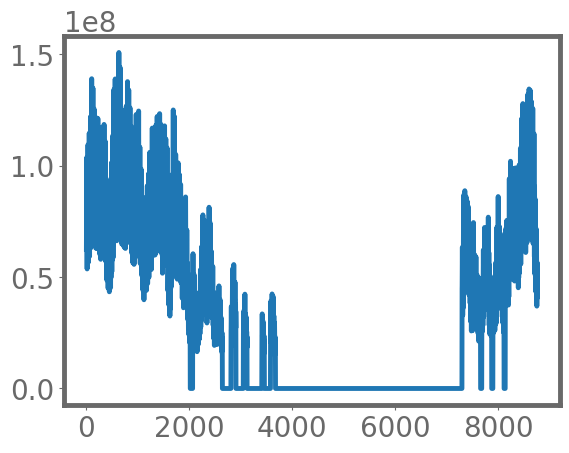

In [5]:
sns.lineplot(dict_heat["global"])

In [ ]:
# Automize saving piecewise approximation
cost_efficiency_stock = pd.read_csv("inputs/cost_efficiency_stock.csv", index_col=0)
dict_cost_efficiency_archetype = {
    "all_stock": cost_efficiency_stock
}

linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost_efficiency_archetype, number_of_segments=3)

In [6]:
list_scc = [0]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame()
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuc", "biogas1", "biogas2", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().transpose()], axis=0, ignore_index=True)

Social cost of carbon: 0


2022-11-18 15:52:49,297 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-18 15:56:00,565 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:801: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:845: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


In [11]:
m_scc.objective

2534664.193177706

In [10]:
m_scc.heat_demand["all_stock"].sum()

277858.3810600422

In [8]:
list_social_cost

[2534664.193177706]

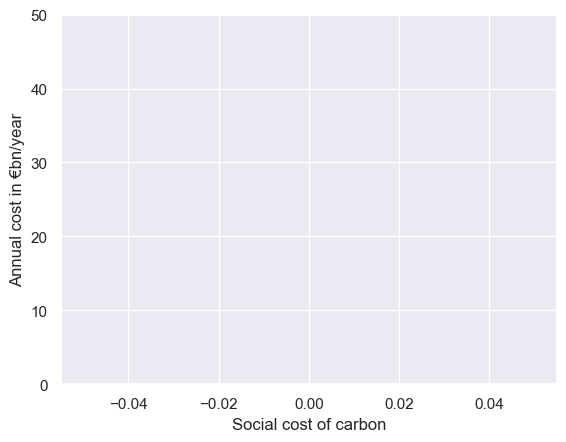

In [7]:


plt.plot(list_scc, list_social_cost)
plt.ylim(0, 50)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

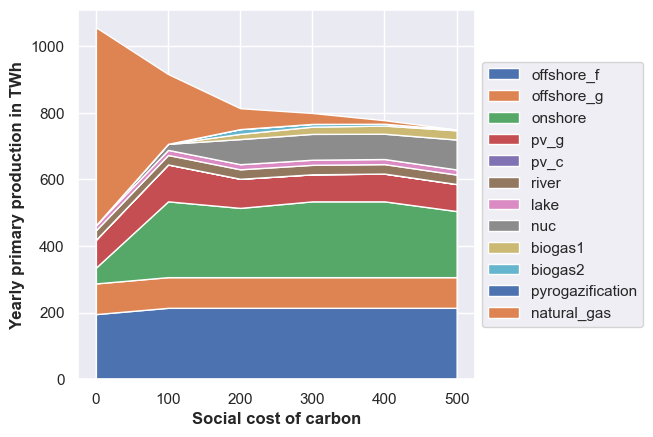

In [45]:
list_primary_production = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

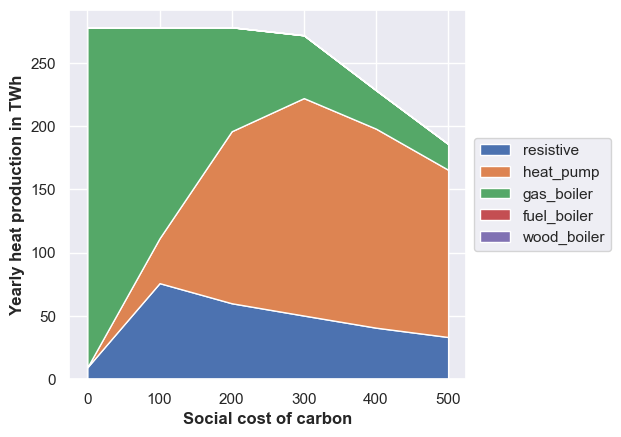

In [6]:
list_heat_generation = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

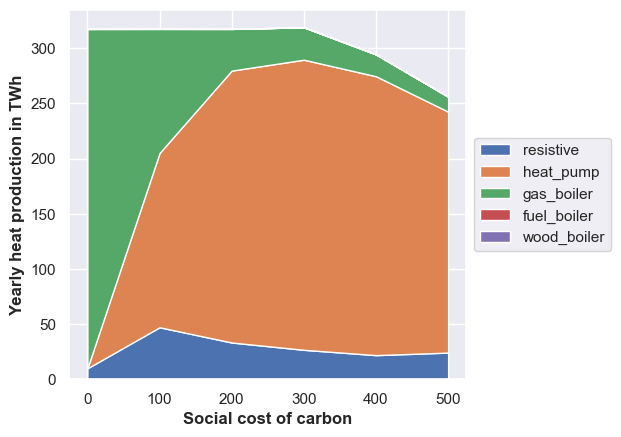

In [46]:
list_heat_generation = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
renovation_rate_df.index = list_scc
renovation_rate_df = renovation_rate_df.stack().reset_index().rename(columns={"level_0": "scc", "level_1": "archetype", 0: "renovation_rate"})
renovation_rate_df

,scc,archetype,renovation_rate
0,0,all_stock,0.000000
1,100,all_stock,0.000000
2,200,all_stock,0.000000
3,300,all_stock,0.022357
4,400,all_stock,0.178385
5,500,all_stock,0.331897


<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

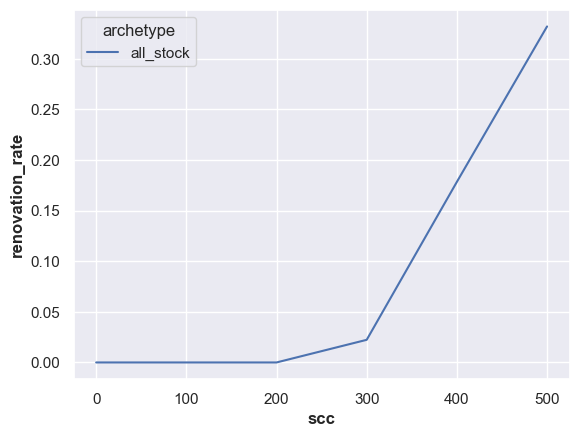

In [8]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

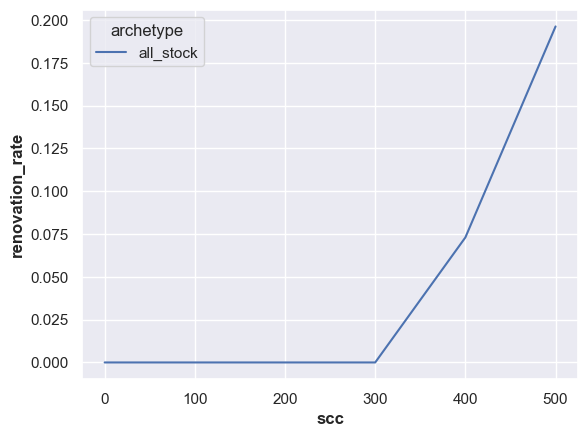

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")